## Реализация TSNE
Выполнил: <b>Северин Никита</b>

In [1]:
from sklearn.datasets import make_s_curve, load_digits
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from scipy.stats import multivariate_normal
from sklearn.metrics import pairwise_distances

In [2]:
#Фиксируем seed для воспроизводимости
seed = 42
np.random.seed(seed)

cm_inferno = plt.cm.get_cmap('inferno') #выбираем colormap
cm_digits = 'tab10'

In [3]:
def show_3D(arr, pos_arr, switch_xy=False, cm=cm_inferno):
    """Визуализация точек в 3х-мерном пространстве"""
    xs, ys, zs = tuple(zip(*arr))
    fig = plt.figure(figsize=(8, 6,))
    ax = fig.add_subplot(111, projection='3d')
    if switch_xy:
        ax.scatter(ys, xs, zs, c=pos_arr, cmap=cm)
        ax.set_xlabel('Y Label')
        ax.set_ylabel('X Label')
    else:
        ax.scatter(xs, ys, zs, c=pos_arr, cmap=cm)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


def show_2D(arr, pos_arr, cm=cm_inferno, add_legend=False, title=''):
    """Визуализация точек в 2х-мерном пространстве"""
    xs, ys = tuple(zip(*arr))
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(xs, ys, c=pos_arr, cmap=cm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    if add_legend:
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Classes")
        ax.add_artist(legend1)
    ax.set_title(title)
    plt.show()

In [4]:
def bin_search_perp_P(distances, perplexity):
    """
    Реализация вещественного двоичного поиска для получения P
    (схожа с реализацией в библиотеке sklearn)
    """
    def update_P_entropy(distances_i, invsigma=1.0):
        P = np.exp(-distances_i * invsigma)
        sumP = sum(P)
        entropy = np.log(sumP) + invsigma * np.sum(distances_i * P) / sumP
        return P / sumP, entropy

    solution_accuracy = 1e-5 #точность решения
    n_samples = distances.shape[0] #количество точек
    max_steps = 50
    pos_inf = float('inf')
    neg_inf = float('-inf')

    P = np.zeros((n_samples, n_samples)) #итоговая матрица P
    inv_sigma = np.ones((n_samples, 1))
    desired_entropy = np.log(perplexity)

    for i in range(n_samples):
        invsigma_min = neg_inf
        invsigma_max = pos_inf

        cur_idx = np.concatenate([range(0, i), range(i+1, n_samples)]).astype(np.int)
        distances_i = distances[i, cur_idx]
        cur_P, cur_entropy = update_P_entropy(distances_i, inv_sigma[i])

        entropy_diff = cur_entropy - desired_entropy
        step = 0
        while np.abs(entropy_diff) > solution_accuracy and step < max_steps:
            #Проверяем, с какой стороны от целевого значения находимся
            if entropy_diff > 0:
                invsigma_min = inv_sigma[i].copy()
                if invsigma_max == pos_inf or invsigma_max == neg_inf:
                    inv_sigma[i] *= 2.0
                else:
                    inv_sigma[i] = (inv_sigma[i] + invsigma_max) / 2.0
            else:
                invsigma_max = inv_sigma[i].copy()
                if invsigma_min == pos_inf or invsigma_min == neg_inf:
                    inv_sigma[i] /= 2.0
                else:
                    inv_sigma[i] = (inv_sigma[i] + invsigma_min) / 2.0

            cur_P, cur_entropy = update_P_entropy(distances_i, inv_sigma[i])
            entropy_diff = cur_entropy - desired_entropy
            step += 1

        P[i, cur_idx] = cur_P
    return P

In [5]:
class CustomTSNE():
    """Класс TSNE"""

    def __init__(self, n_components=2, perplexity=30, early_exaggeration=12, learning_rate=0.5, n_iter=1000, random_state=42):
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state
        self.metric = 'euclidean'
        self.warm_steps = 100
        self.momentum_steps = 20
        self.min_val = 1e-12
        self.eta = 500
        self.min_grad_gain = 0.01

    def _init_Y(self, n_samples):
        """Инициализация Y"""
        random_state = np.random.RandomState(self.random_state)
        return 1e-4 * random_state.randn(
                n_samples, self.n_components).astype(np.float32)


    def _get_p_matrix(self, X):
        """Вычисляет матрицу P"""
        distances = pairwise_distances(X, metric=self.metric, squared=True)
        conditional_P = bin_search_perp_P(distances, self.perplexity)
        P = (conditional_P + conditional_P.T) / (2*X.shape[0])
        return np.maximum(P, self.min_val)


    def _get_q_matrix(self, Y):
        """"Вычисляет матрицу Q"""
        distances = pairwise_distances(Y, metric=self.metric, squared=True)
        distances = 1.0 / (1 + distances)
        distances[range(distances.shape[0]), range(distances.shape[0])] = 0.0
        Q = distances / np.sum(distances)
        return np.maximum(Q, self.min_val), distances


    def fit_transform(self, X):
        """Преобразует матрицу X"""

        #приводим к диапозону от 0 до 1
        X = X.copy()
        sum_X = np.sum(np.abs(X), axis=1)
        for i in range(X.shape[0]):
            X[i, :] /= sum_X[i]

        n_samples = X.shape[0]
        P = self._get_p_matrix(X) * self.early_exaggeration
        Y = self._init_Y(n_samples)
        dY = np.zeros((n_samples, self.n_components))
        iY = np.zeros((n_samples, self.n_components))
        grad_gains = np.ones((n_samples, self.n_components))

        for k in tqdm(range(self.n_iter)):
            Q, y_distances = self._get_q_matrix(Y)
            
            #вычисление градиента
            PQ_diff = P - Q
            for i in range(n_samples):
                dY[i, :] = 4 * np.sum(np.tile(PQ_diff[i, :] * y_distances[i, :],\
                            (self.n_components, 1)).T * (Y[i, :] - Y), axis=0)                    

            grad_gains = (grad_gains + 0.2) * ((dY > 0.0) != (iY > 0.0)) + \
                        (grad_gains * 0.8) * ((dY > 0.0) == (iY > 0.0))
            grad_gains[grad_gains < self.min_grad_gain] = self.min_grad_gain

            #обновление Y
            iY = self.learning_rate * iY - self.eta * (grad_gains * dY)
            Y += iY
            Y -= np.tile(np.mean(Y, 0), (n_samples, 1))

            if k == self.warm_steps:
                P /= self.early_exaggeration
        return Y

In [6]:
s_curve = make_s_curve(500, 0.0, random_state=seed)

## Визуализация буквы "S"

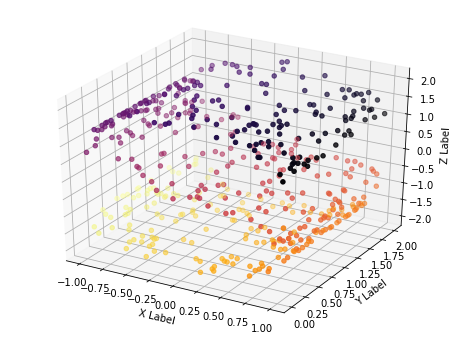

In [166]:
show_3D(s_curve[0], s_curve[1], False)

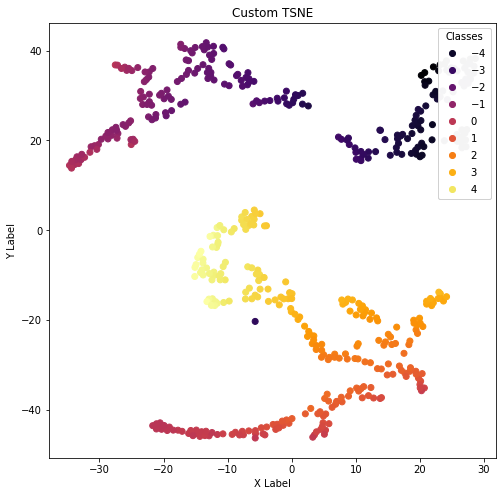

In [168]:
S_curve_2D = CustomTSNE(n_components=2, perplexity=15, early_exaggeration=12, random_state=seed).fit_transform(s_curve[0])
show_2D(S_curve_2D, s_curve[1], cm_inferno, add_legend=True, title='Custom TSNE')

Форма буквы S прослеживается, хотя желтые и оранжевые точки поменялись местами

## Визуализация датасета Digits (цифры 0..9)

In [7]:
digits = load_digits()
X = digits['data']
y = digits['target']

print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: (1797, 64)
y.shape: (1797,)


100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


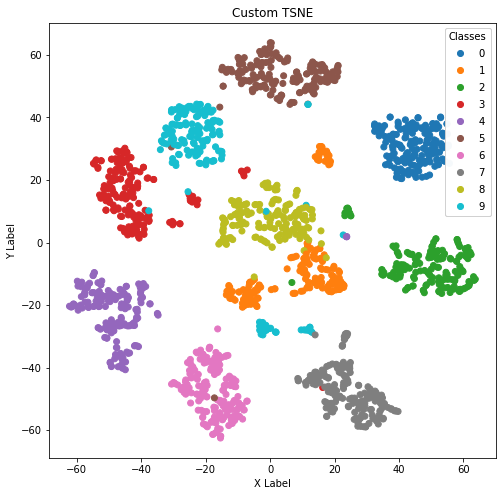

In [8]:
X_2D_custom = CustomTSNE(n_components=2, perplexity=15, early_exaggeration=12, random_state=seed).fit_transform(X)
show_2D(X_2D_custom, y, cm_digits, add_legend=True, title='Custom TSNE')

Визуализация с помощью TSNE из Sklearn

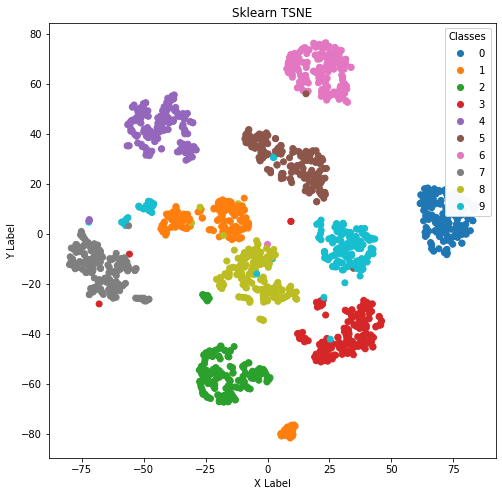

In [148]:
from sklearn.manifold import TSNE
X_2D = TSNE(n_components=2, perplexity=15, early_exaggeration=12, random_state=seed).fit_transform(X)
show_2D(X_2D, y, cm_digits, add_legend=True, title='Sklearn TSNE')

Как видно в обоих случаях, классы достаточно хорошо отделились на изображении.